In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# Add the directory containing diffusive_nested_sampling to sys.path
sys.path.append(os.path.abspath( "../.."))
import spike_and_slab

In [3]:
def log_likelihood(x):
    '''
    20-D spike and slab likelihood function

    @param x : coordinate
    @return L : likelihood
    '''
    u = 0.01
    v = 0.1

    # Spike
    t1 = np.sum(-0.5 * (x / v) ** 2) - x.size * np.log(v * np.sqrt(2 * np.pi))
    
    # Slab
    t2 = np.sum(-0.5 * ((x - 0.031) / u) ** 2) - x.size * np.log(u * np.sqrt(2 * np.pi)) + np.log(100.0)

    logL = np.logaddexp(t1, t2)
    return logL

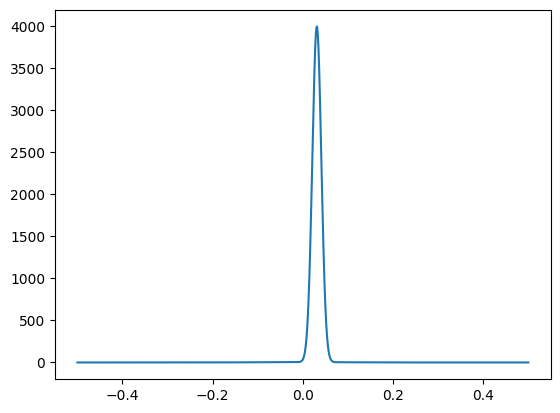

In [4]:
x = np.linspace(-0.5, 0.5, 10000)
y = np.exp([log_likelihood(x_i) for x_i in x])
plt.plot(x, y)
# plt.plot(x, y_spike)
# plt.plot(x, y_slab)
plt.show()

In [5]:
chain, levels, js = spike_and_slab.main()

/home/tom-egg/Research/nested_sampling/diffusive_nested_sampling/dns.py:31: RuntimeWarning: divide by zero encountered in log
  self.levels = [Level(0, np.log(0.0), prev=None)]
100%|██████████| 333/333 [09:23<00:00,  1.69s/it]


999


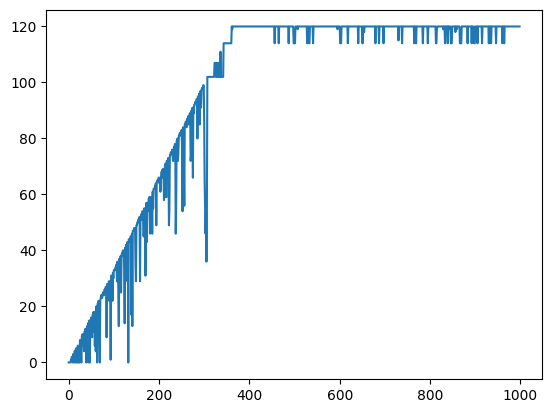

In [6]:
print(len(js))
y = js
x = range(len(y))
plt.plot(x, y)
plt.show()

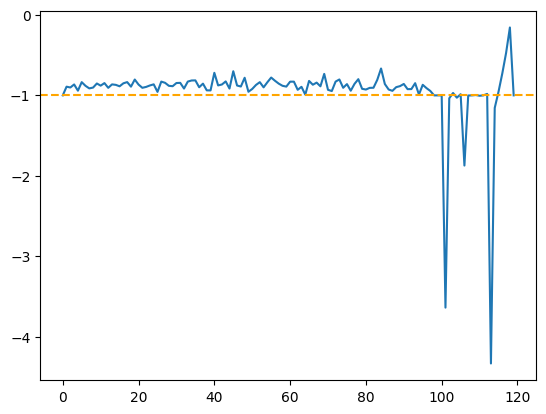

In [7]:
Xs = np.array([level.get_log_X for level in levels])
y = Xs[1:] - Xs[:-1]
x = range(len(y))
plt.plot(x, y)
plt.axhline(y=-1.0,linestyle='--', color='orange')
plt.show()

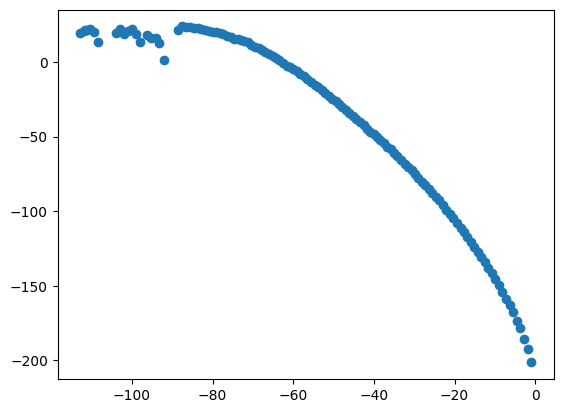

In [8]:
logL = [level.log_likelihood_bound for level in levels]
logX = [level.get_log_X for level in levels]
plt.scatter(logX, logL)

In [9]:
np.exp(logL)

array([0.00000000e+00, 3.43630163e-88, 2.23184690e-84, 2.45347381e-81,
       2.73177662e-78, 5.37445737e-76, 1.84501583e-73, 1.62602011e-71,
       1.40805497e-69, 1.50456417e-67, 1.35106266e-65, 5.76061452e-64,
       2.74450434e-62, 9.79642055e-61, 5.70112779e-59, 1.52295148e-57,
       3.67005351e-56, 1.60407218e-54, 3.76428541e-53, 9.18265751e-52,
       2.71353255e-50, 4.98222331e-49, 1.12686641e-47, 2.80415628e-46,
       5.77935313e-45, 1.04373865e-43, 2.30211654e-42, 5.65726345e-41,
       5.09902700e-40, 6.97812899e-39, 1.30565881e-37, 1.76329180e-36,
       1.52391196e-35, 1.57088232e-34, 3.34563737e-33, 2.64564335e-32,
       2.34686091e-31, 2.18910291e-30, 3.15494027e-29, 3.18616481e-28,
       4.22144908e-27, 6.42460804e-26, 1.90480261e-25, 2.31161021e-24,
       1.75618010e-23, 1.44178995e-22, 1.38629482e-21, 3.61300539e-21,
       3.87298674e-20, 4.75111534e-19, 2.41194338e-18, 2.65769867e-17,
       2.14908522e-16, 1.32025263e-15, 8.32126432e-15, 8.22181885e-14,
      

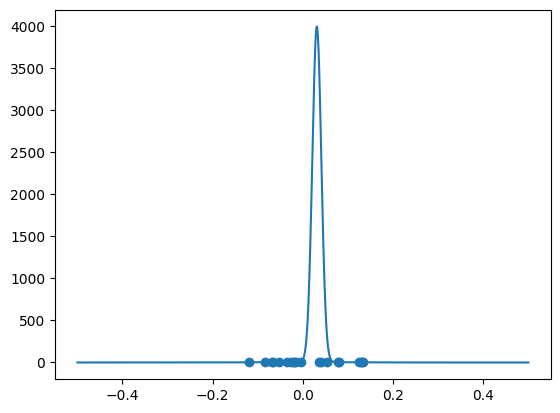

In [10]:
pos = chain['x'][-20:][:,0]
x = np.linspace(-0.5, 0.5, 10000)
y = np.exp([log_likelihood(x_i) for x_i in x])
plt.plot(x, y)
plt.scatter(pos, np.zeros(len(pos)))
plt.show()